In [1]:
import cv2
import numpy as np
import pandas as pd
import random
import pickle
from PIL import Image
from os.path import isfile
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

In [65]:
BOX_SIZE = 256

def preprocess_image(img):
    from keras.applications.densenet import preprocess_input
    return preprocess_input(img)


def get_branch_model(inp_shape):
    from keras.applications.densenet import DenseNet121
    model = DenseNet121(input_shape=inp_shape, include_top=False, weights=None, pooling='max')
    return model


def build_model(img_shape, activation='sigmoid'):
    from keras import backend as K
    from keras.optimizers import Adam
    from keras.engine.topology import Input
    from keras.layers import Concatenate, Conv2D, Dense, Flatten, Lambda, Reshape
    from keras.models import Model, load_model

    optim = Adam(lr=0.0001)
    branch_model = get_branch_model(img_shape)

    mid = 32
    xa_inp = Input(shape=branch_model.output_shape[1:], name='hm_inp_a')
    xb_inp = Input(shape=branch_model.output_shape[1:], name='hm_inp_b')
    x1 = Lambda(lambda x: x[0] * x[1], name='lambda_1')([xa_inp, xb_inp])
    x2 = Lambda(lambda x: x[0] + x[1], name='lambda_2')([xa_inp, xb_inp])
    x3 = Lambda(lambda x: K.abs(x[0] - x[1]), name='lambda_3')([xa_inp, xb_inp])
    x4 = Lambda(lambda x: K.square(x), name='lambda_4')(x3)
    x = Concatenate(name='concat_1')([x1, x2, x3, x4])
    x = Reshape((4, branch_model.output_shape[1], 1), name='reshape1')(x)

    # Per feature NN with shared weight is implemented using CONV2D with appropriate stride.
    x = Conv2D(mid, (4, 1), activation='relu', padding='valid', name='hm_conv_2d_1')(x)
    x = Reshape((branch_model.output_shape[1], mid, 1), name='hm_reshape_2')(x)
    x = Conv2D(1, (1, mid), activation='linear', padding='valid', name='hm_conv_2d_2')(x)
    x = Flatten(name='flatten')(x)

    # Weighted sum implemented as a Dense layer.
    x = Dense(1, use_bias=True, activation=activation, name='weighted-average')(x)
    head_model = Model([xa_inp, xb_inp], x, name='head')

    ########################
    # SIAMESE NEURAL NETWORK
    ########################
    # Complete model is constructed by calling the branch model on each input image,
    # and then the head model on the resulting 512-vectors.
    img_a = Input(shape=img_shape)
    img_b = Input(shape=img_shape)
    xa = branch_model(img_a)
    xb = branch_model(img_b)
    x = head_model([xa, xb])
    model = Model([img_a, img_b], x, name='full_model')
    model.compile(optim, loss='binary_crossentropy', metrics=['binary_crossentropy', 'acc'])
    return model, branch_model, head_model

def shuffle_weights(model, weights=None):
    """Randomly permute the weights in `model`, or the given `weights`.
    This is a fast approximation of re-initializing the weights of a model.
    Assumes weights are distributed independently of the dimensions of the weight tensors
      (i.e., the weights have the same distribution along each dimension).
    :param Model model: Modify the weights of the given model.
    :param list(ndarray) weights: The model's weights will be replaced by a random permutation of these weights.
      If `None`, permute the model's current weights.
    """
    if weights is None:
        weights = model.get_weights()
    weights = [np.random.permutation(w.flat).reshape(w.shape) for w in weights]
    # Faster, but less random: only permutes along the first dimension
    # weights = [np.random.permutation(w) for w in weights]
    model.set_weights(weights)

def get_trained_model():
    model, branch_model, head_model = build_model(img_shape=(BOX_SIZE, BOX_SIZE, 3))
    model.load_weights('ft_v5_512px_finetune_0_final_v2_0.969993.model')
    initial_weights = model.get_weights()
    shuffle_weights(model, initial_weights)
    return model, branch_model, head_model

In [66]:
def read_single_image(path):
    try:
        img = np.array(Image.open(path))
    except:
        try:
            img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        except:
            print('Fail')
            return None

    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    if img.shape[2] == 2:
        img = img[:, :, :1]

    if img.shape[2] == 1:
        img = np.concatenate((img, img, img), axis=2)

    if img.shape[2] > 3:
        img = img[:, :, :3]

    return img


def read_cropped_image(p, x0, y0, x1, y1, img_shape=(224, 224, 3)):
    anisotropy = 2.15
    crop_margin = 0.05

    # Read the image
    img = read_single_image(p)
    size_x, size_y = img.shape[1], img.shape[0]

    dx = x1 - x0
    dy = y1 - y0
    x0 -= dx * crop_margin
    x1 += dx * crop_margin + 1
    y0 -= dy * crop_margin
    y1 += dy * crop_margin + 1
    if x0 < 0: x0 = 0
    if x1 > size_x: x1 = size_x
    if y0 < 0: y0 = 0
    if y1 > size_y: y1 = size_y
    dx = x1 - x0
    dy = y1 - y0
    if dx > dy * anisotropy:
        dy = 0.5 * (dx / anisotropy - dy)
        y0 -= dy
        y1 += dy
    else:
        dx = 0.5 * (dy * anisotropy - dx)
        x0 -= dx
        x1 += dx

    if x0 < 0: x0 = 0
    if x1 > size_x: x1 = size_x
    if y0 < 0: y0 = 0
    if y1 > size_y: y1 = size_y
    x0, y0, x1, y1 = int(x0), int(y0), int(x1), int(y1)

    if y0 != y1 and x0 != x1:
        img = img[y0:y1, x0:x1, :]
    img = cv2.resize(img, (img_shape[1], img_shape[0]), interpolation=cv2.INTER_LINEAR)
    if len(img.shape) == 2:
        img = np.concatenate((img, img, img), axis=2)

    return img

In [73]:
def normalize_array(arr):
    arr = 255.0 * (arr - arr.min()) / (arr.max() - arr.min())
    return arr


def create_activation_map_for_images(model, images, preproc_image):
    images_preproc = preproc_image(images.astype(np.float32))
    preds = model.predict(images_preproc)
    print('Shape of predictions: {}'.format(preds.shape))

    hmaps = []
    for z in range(images.shape[0]):
        img_orig = images[z]
        heatmap = preds[z]
    
        # Uncomment it to emulate RELU activation
        # heatmap[heatmap < 0] = 0

        ch0 = np.zeros_like(heatmap[:, :, 0])
        ch1 = np.zeros_like(heatmap[:, :, 0])
        ch2 = np.zeros_like(heatmap[:, :, 0])
        c1=ch1-ch2

        # Find how often maximum is in each pixel.
        for k in range(heatmap.shape[2]):
            p = heatmap[:, :, k]
            mx = p.max()
            if mx == 0:
                continue
            for i in range(heatmap.shape[0]):
                for j in range(heatmap.shape[1]):
                    if p[i, j] == mx:
                        ch0[i, j] += 1
                        ch2[i, j] += 1

        for i in range(heatmap.shape[0]):
            for j in range(heatmap.shape[1]):
                mn = heatmap[i, j].min()
                mx = heatmap[i, j].max()
                mean = heatmap[i, j].mean()
                std = heatmap[i, j].std()
                # print(i, j, mn, mx, mean, std, mx - mn)
                ch1[i, j] = std

        ch0 = normalize_array(ch0)
        ch1 = normalize_array(ch1)
        ch2 = normalize_array(ch2)
        ch = np.stack((ch0, ch1, ch2), axis=2)

        ch = cv2.resize(ch.astype(np.uint8), (img_orig.shape[1], img_orig.shape[0]), interpolation=cv2.INTER_LANCZOS4)

        ch = normalize_array(ch)

        heat = (0.2 * img_orig + (0.1 * img_orig * ch) / 255 + 0.7 * ch).astype(np.uint8)
        heat = heat.astype(np.uint8)
        heat = normalize_array(heat)

        img_line = np.concatenate(
            (img_orig, heat), axis=1
        )
        hmaps.append(img_line)

    return np.array(hmaps)


def create_activation_maps():
    from keras.models import Model
    model, branch_model, head_model = get_trained_model()

    x = branch_model.layers[-3].output
    branch_model_modified = Model(inputs=branch_model.inputs, outputs=x)
    # print(branch_model_modified.summary())
    from glob import glob
    names=[]
    images=[]
    for item in glob(".\WCE\*"):
        images.append(cv2.resize(cv2.imread(item),(256,256)))
        names.append(item.split("\\")[2])

    img_line = create_activation_map_for_images(branch_model_modified, np.array(images), preprocess_image)
    import matplotlib.pylab as plt

    row=4
    col=2
    fig, axs = plt.subplots(row,col,figsize=(15,15))
    k=0
    for i in range(row):
        for j in range(col):
            if k== 7:
                break
            img = img_line[k].astype(np.uint8)
            img_path = names[k]
            axs[i,j].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            axs[i,j].set(ylabel=names[k].split(".")[0])
            # cv2.imwrite(img_path, img)
            print('Heatmap for image: {}'.format(names[k]))
            k=k+1
            # Image(img_line[i].astype(np.uint8))
            # display(Image(filename=img_path))
    fig.savefig('WCE_HeatMap1.png', dpi=100)

Shape of predictions: (7, 8, 8, 1024)
Heatmap for image: Cardia.jpg
Heatmap for image: Colon.png
Heatmap for image: Duodenum.jpg
Heatmap for image: Esophagus.png
Heatmap for image: Ileum.png
Heatmap for image: Jejunum.png
Heatmap for image: Pylorus.png


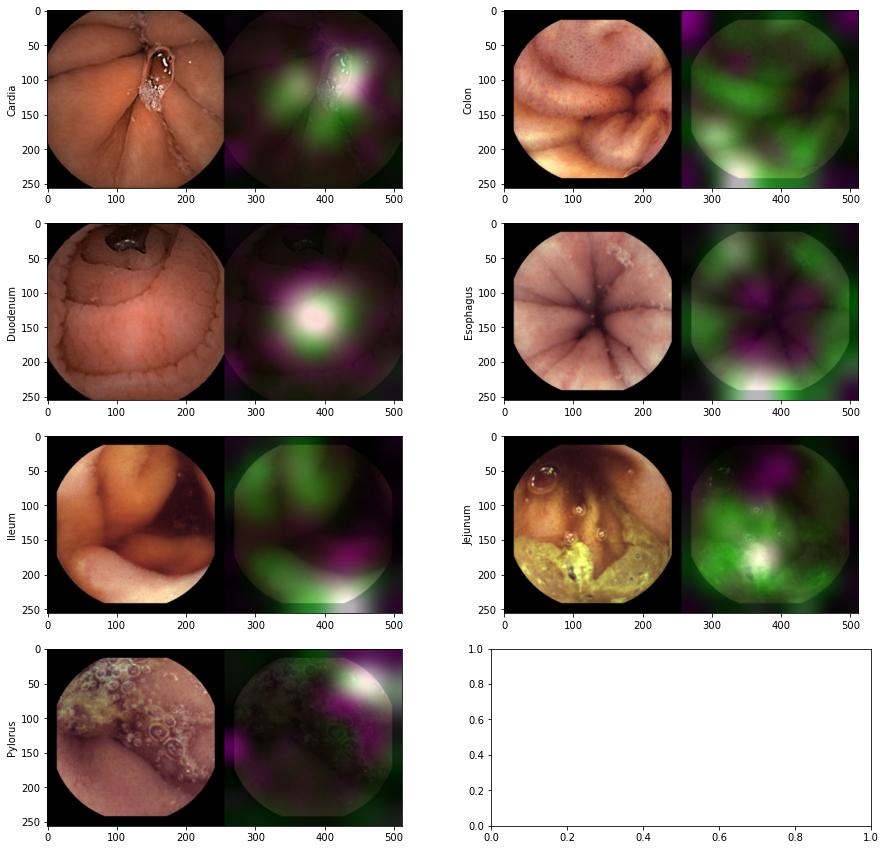

In [78]:
create_activation_maps()

In [23]:
from sklearn.manifold import TSNE
import tensorflow as tf
from glob import glob

# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))

    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)

    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range


def create_tnse_plot():
    from keras.models import Model
    model, branch_model, head_model = get_trained_model()

    # print(branch_model_modified.summary())
    from glob import glob
    names=[]
    images=[]
    for item in glob(".\CE\*"):
        images.append(cv2.resize(cv2.imread(item),(256,256)))
        names.append(item.split("\\")[2])
    features=[]
    for image in images:       
        image=tf.expand_dims(image,axis=0)
        features.append(branch_model.predict(image))
    
    import matplotlib.pylab as plt

    fig = plt.figure()
    ax = fig.add_subplot(111)
    for label,feature in enumerate(features):
        tsne = TSNE(n_components=2,perplexity=5).fit_transform(tf.transpose(feature))
        tx = tsne[:, 0]
        ty = tsne[:, 1]
        
        tx = scale_to_01_range(tx)
        ty = scale_to_01_range(ty)
        ax.scatter(tx, ty, label=names[label].split(".")[0])
    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
    ax.set_xlabel('Projected data on x-axis')
    ax.set_ylabel('Projected data on y-axis')
    plt.tight_layout()
    fig.savefig('tsneCE2.png', dpi=100)
def create_tnse_plot3D():
    from keras.models import Model
    model, branch_model, head_model = get_trained_model()

    # print(branch_model_modified.summary())
    from glob import glob
    names=[]
    images=[]
    for item in glob(".\CE\*"):
        images.append(cv2.resize(cv2.imread(item),(256,256)))
        names.append(item.split("\\")[2])
    features=[]
    for image in images:       
        image=tf.expand_dims(image,axis=0)
        features.append(branch_model.predict(image))
    
    import matplotlib.pylab as plt

    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    for label,feature in enumerate(features):
        tsne = TSNE(n_components=3).fit_transform(tf.transpose(feature))
        tx = tsne[:, 0]
        ty = tsne[:, 1]
        tz = tsne[:, 2]
        
        tx = scale_to_01_range(tx)
        ty = scale_to_01_range(ty)
        tz = scale_to_01_range(tz)
        ax.scatter(tx, ty,tz, label=names[label].split(".")[0])
    ax.legend(bbox_to_anchor=(1.07, 1.0), loc='upper left')
    ax.set_xlabel('Projected data on x-axis')
    ax.set_ylabel('Projected data on y-axis')
    plt.tight_layout()
    fig.savefig('tsne3DCE2.png', dpi=100)

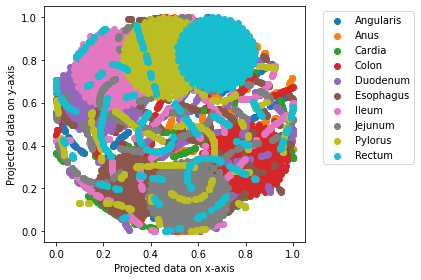

In [8]:
create_tnse_plot()